In [1]:
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import math
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Bayesian linear model

class Linear_Model:
    '''
    The mother of all linear model.
    Any descendents must follow three steps:
        - _basis_funcs
        - _fit, _reg_fit
        - _predict
    '''
    
    def _basis_funcs(self, basis_funcs):
        self.basis_funcs = basis_funcs
    
    def _design_matrix(self, X):
        mat = []
        for i in X:
            line = []
            for f in self.basis_funcs:
                line.append(f(i))
            mat.append(line)
        # Add a reshape term to control the demension
        return np.array(mat).reshape(len(mat), -1) 
        
    def _fit(self, X, y, lam):
        dmat = self._design_matrix(X)
        imat = lam * np.identity(dmat.shape[1]) + dmat.T @ dmat
        self.w = np.linalg.pinv(imat) @ dmat.T @ y
        
    def _predict(self, X):
        return self._design_matrix(X) @ self.w
    

class Linear_Regression(Linear_Model):
    
    def fit(self, X, y, lam=0):
        
        def l(n):
            def f(x):
                return x[n]
            return f
        L = [l(i) for i in range(X.shape[1])]
        
        self._basis_funcs(L)
        self._fit(X, y, lam)        
        
    def predict(self, X):
        return self._predict(X)

    
class RBF_Regression(Linear_Model):
    
    def fit(self, X, y, lam=0, var=2):
        
        # To construct a series of RBF kernel given specific anchor
        def l(n, var):
            def f(x):
                return math.e**(-(x-n)**2/var**2)
            return f

        L = [l(X_train[i][0], var) for i in range(X_train.shape[0])]
    
        self._basis_funcs(L)
        self._fit(X, y, lam)        
        
    def predict(self, X):
        return self._predict(X)

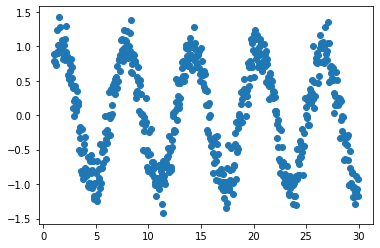

In [11]:
X = np.arange(1, 30, 0.05)
y = np.sin(X) + np.random.randn(X.shape[0]) / 5
X = X.reshape(-1, 1)
y = y.reshape(-1, 1)
X_train, X_test, y_train, y_test = train_test_split(X, y)

plt.scatter(X, y)
plt.show()

0.5295235736040503


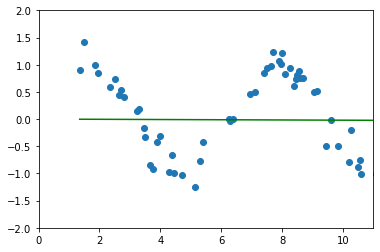

In [12]:
# Linear Regression
M = Linear_Regression()
M.fit(X_train, y_train)
print(mean_squared_error(M.predict(X_test), y_test))

plt.scatter(X_test, y_test)
X_test = np.sort(X_test, axis=0)
plt.plot(X_test, M.predict(X_test), 'g')
plt.axis([0, 11, -2, 2])
plt.show()

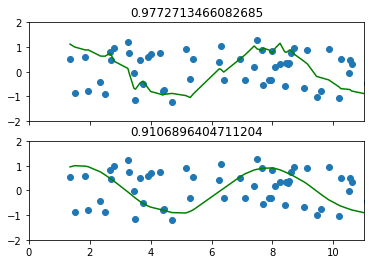

In [16]:
# RBF Regression

fig, (up, down) = plt.subplots(2, 1, sharex=True, sharey=True)

M = RBF_Regression()
M.fit(X_train, y_train, 0, 0.5)

up.set_title("%s"%(mean_squared_error(M.predict(X_test), y_test)))
up.scatter(X_test, y_test)
X_test = np.sort(X_test, axis=0)
up.plot(X_test, M.predict(X_test), 'g')


M = RBF_Regression()
M.fit(X_train, y_train, 10, 0.5)

down.set_title("%s"%(mean_squared_error(M.predict(X_test), y_test)))
down.scatter(X_test, y_test)
X_test = np.sort(X_test, axis=0)
down.plot(X_test, M.predict(X_test), 'g')


plt.axis([0, 11, -2, 2])
plt.show()

In [7]:
# Bayesian linear model

class Bayesian_Linear_Model:
    '''
    The mother of all bayesian linear model.
    Any descendents must follow three steps:
        - _basis_funcs
        - _fit, _reg_fit
        - _predict
    '''
    
    def _basis_funcs(self, basis_funcs):
        self.basis_funcs = basis_funcs
    
    def _design_matrix(self, X):
        mat = []
        for i in X:
            line = []
            for f in self.basis_funcs:
                line.append(f(i))
            mat.append(line)
        return np.array(mat)    
        
    def _fit(self, X, y, a, b):
        '''
        a: the prior of distribution of weights
        b: the instrinsic value of variance of target value
        '''
        dmat = self._design_matrix(X)
        # The variance of weights posterior
        wv = a * np.eye(dmat.shape[1]) + b * (dmat.T @ dmat)
        # The expectation of weights
        self.w = (b * np.linalg.inv(wv)) @ dmat.T @ y
        # Store the hyper parameters
        self.b = b
        self.a = a

    # Return the expectation of the predicted value    
    def _predict(self, X):
        return self._design_matrix(X) @ self.w
        
    # Return the variance of the predicted distribution
    def _var(self, X):
        dmat = self._design_matrix(X)
        wv = self.a * np.eye(dmat.shape[1]) + self.b * (dmat.T @ dmat)
        return 1/self.b + dmat @ np.linalg.inv(wv) @ dmat.T

    
class Bayesian_Linear_Regression(Bayesian_Linear_Model):
    
    def fit(self, X, y, a, b):
        
        def l(n):
            def f(x):
                return x[n]
            return f
        L = [l(i) for i in range(X.shape[1])]
        
        self._basis_funcs(L)
        self._fit(X, y, a, b)        
        
    def predict(self, X, return_var=False):
        if return_var == True:
            return self._predict(X), self._var(X)
        return self._predict(X)

In [8]:
L = Bayesian_Linear_Regression()
L.fit(X_train, y_train, 1, 1)
y_pred, var = L.predict(X_test, True) 
mean_squared_error(y_pred, y_test)

23981.781769215173

In [37]:
# Evidence approximation, providing f(x) = x

a = 10000
b = 10
n = len(X_train)
for _ in range(5):
    mat = b * (X_train.T @ X_train)
    s_n = a * np.eye(X_train.shape[1]) + mat
    m_n = b * np.linalg.inv(s_n) @ X_train.T @ y_train
    eig, _ = np.linalg.eig(mat)
    r = sum(eig / (eig + a))
    a = r / (m_n.T @ m_n)
    b = 1 / ((1 / (n-r)) * np.sum(np.square(y_train - (X_train @ m_n))))
    print(a, b)    

0.007787345030660809 4.061189485206493e-05
0.007047427148771827 4.0746118884546554e-05
0.007030156125879337 4.0746846340797364e-05
0.007029763672520123 4.074686130197734e-05
0.007029754760963882 4.074686164089173e-05
